In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread

In [163]:
x_train_tmp_folder_path = r"C:\Hyundai GAN\Hyundai_full_data_circular\new_range_inputs\new_inputs\temp_new"
x_train_dsp_folder_path = r"C:\Hyundai GAN\Hyundai_full_data_circular\new_range_inputs\new_inputs\disp_new"
y_train_folder_path = r"C:\Hyundai GAN\Hyundai_full_data_circular\Data\CIRCULAR_VANE_Shape_Images_1559"

x_tmp_elements = os.listdir(x_train_tmp_folder_path)
x_dsp_elements = os.listdir(x_train_dsp_folder_path)
y_elements = os.listdir(y_train_folder_path)


In [164]:
def sort_img(path):

    dict1 = {}
    
    lst = [0]*1560
    for i in path:
        dict1[int(i[i.index('(')+1:i.index(')')])] = i
        
    
    for j in range(1,1560):
        lst[j]= dict1[j]
    return lst[1:]



In [165]:
x_tmp_elements = sort_img(x_tmp_elements)
x_dsp_elements = sort_img(x_dsp_elements)
y_elements = sort_img(y_elements)

In [166]:
y_elements[:15]

['vaneimg (1).jpeg',
 'vaneimg (2).jpeg',
 'vaneimg (3).jpeg',
 'vaneimg (4).jpeg',
 'vaneimg (5).jpeg',
 'vaneimg (6).jpeg',
 'vaneimg (7).jpeg',
 'vaneimg (8).jpeg',
 'vaneimg (9).jpeg',
 'vaneimg (10).jpeg',
 'vaneimg (11).jpeg',
 'vaneimg (12).jpeg',
 'vaneimg (13).jpeg',
 'vaneimg (14).jpeg',
 'vaneimg (15).jpeg']

In [1]:
# DEVELOPING X_train MATRIX

def get_images(tmp_elements,disp_elements,y_elements,size):
  X= np.zeros((size,256,256,2))
  Y= np.zeros((size,256,256,1))
  for index, (tmp_element, dsp_element) in enumerate(zip(tmp_elements, disp_elements)):
      # Load images for each channel
      tmp_element_path = os.path.join(x_train_tmp_folder_path, tmp_element)
      dsp_element_path = os.path.join(x_train_dsp_folder_path, dsp_element)
      img_tmp = imread(tmp_element_path)
      img_dsp = imread(dsp_element_path)

      # Reshape images for each channel
      img_tmp = img_tmp.reshape((256,256, 1))
      img_dsp = img_dsp.reshape((256,256, 1))

      # Combine channels
      img_combined = (np.concatenate((img_tmp, img_dsp), axis=2)-0.5)/0.5

      # Assign to X_train
      X[index] = img_combined

  # DEVELOPING Y_train MATRIX
  for index,Y_train_element in enumerate(y_elements):
      element_path = os.path.join(y_train_folder_path, Y_train_element)
      img = imread(element_path)
      img = np.mean(img, axis=2)
      img = img/255
      img = img.reshape((256, 256, 1))
      Y[index] = img
  return X,Y

In [2]:
x,y = get_images(x_tmp_elements,x_dsp_elements,y_elements,len(x_tmp_elements))

NameError: name 'x_tmp_elements' is not defined

In [3]:
x.shape,y.shape

NameError: name 'x' is not defined

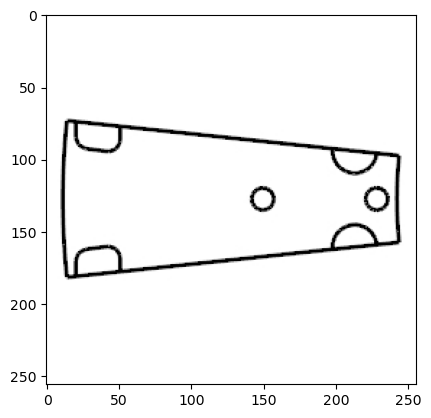

In [170]:
img=imread(os.path.join(y_train_folder_path,y_elements[15]))
plt.imshow(img)

In [171]:
x.max(),x.min(),y.max(),y.min()

(1.0, -1.0, 1.0, -1.0)

In [172]:
train_data=tf.data.Dataset.from_tensor_slices((x[:500],y[:500]))

In [173]:
train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 2), dtype=tf.float64, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float64, name=None))>

In [174]:
def encoder_block(input,filters,batch_norm=True):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  x=tf.keras.layers.Conv2D(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input)
  if batch_norm:
    x=tf.keras.layers.BatchNormalization()(x,training=True)
  x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  return x

def decoder_block(input,skip_con,filters,dropout=True):
  init=tf.keras.initializers.RandomNormal(stddev=0.02)
  x=tf.keras.layers.Conv2DTranspose(filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(input)
  x=tf.keras.layers.BatchNormalization()(x,training=True)
  if dropout:
    x=tf.keras.layers.Dropout(0.5)(x,training=True)
  x=tf.keras.layers.Concatenate()([x,skip_con])
  x=tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  return x

def generator_model(input_shape=(256,256,2)):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  input=tf.keras.layers.Input(input_shape)
  e1=encoder_block(input,64,batch_norm=False)
  e2=encoder_block(e1,128)
  e3=encoder_block(e2,256)
  e4=encoder_block(e3,512)
  e5=encoder_block(e4,512)
  e6=encoder_block(e5,512)
  e7=encoder_block(e6,512)

  b=tf.keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
  #b=tf.keras.layers.BatchNormalization()(b,training=True)
  b=tf.keras.layers.ReLU()(b)

  d1=decoder_block(b,e7,512)
  d2=decoder_block(d1,e6,512)
  d3=decoder_block(d2,e5,512)
  d4=decoder_block(d3,e4,512,dropout=False)
  d5=decoder_block(d4,e3,256,dropout=False)
  d6=decoder_block(d5,e2,128,dropout=False)
  d7=decoder_block(d6,e1,64,dropout=False)

  output=tf.keras.layers.Conv2DTranspose(1,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
  output=tf.keras.layers.Activation('tanh')(output)
  model=tf.keras.Model(input,output)
  return model

loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(generated_output, g_output, target):
  lambda_=100
  gan_loss = loss(tf.ones_like(generated_output), generated_output)
  l1_loss = tf.reduce_mean(tf.abs(tf.cast(target,tf.float64) - tf.cast(g_output,tf.float64)))
  g_loss_total = tf.cast(gan_loss,tf.float64) + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

In [175]:
generator=generator_model()

In [176]:
def discriminator_model(input_shape=(256,256,2)):
  init=tf.keras.initializers.RandomNormal(stddev=0.02,seed=42)
  src_img=tf.keras.layers.Input(input_shape)
  tar_img=tf.keras.layers.Input((256,256,1))
  merged=tf.keras.layers.Concatenate()([src_img,tar_img])
  x=tf.keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(merged)
  x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)

  x=tf.keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)

  x=tf.keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)

  x=tf.keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)

  x=tf.keras.layers.Conv2D(1,(4,4),padding='same',kernel_initializer=init)(x)
  model=tf.keras.Model([src_img,tar_img],x)
  return model

def disc_loss(real_output,fake_output):
  real_loss=loss(tf.ones_like(real_output),real_output)
  fake_loss=loss(tf.zeros_like(fake_output),fake_output)
  return real_loss+fake_loss

In [177]:
discriminator=discriminator_model()

In [178]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [179]:
gen_opt=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)
disc_opt=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)

In [180]:
def compare_images(input_test,target,epoch):
  generated = generator(input_test, training=False)
  plt.figure(figsize=(15,5))

  images_list = [target[0], generated[0]]
  title = ['Real (ground truth)', 'Generated Image (fake)']

  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    plt.imshow(images_list[i] * 0.5 + 0.5,cmap='gray')
    plt.axis('off')
  plt.suptitle(f'EPOCH {epoch}')
  plt.show()

In [181]:
#@tf.function

#helper function
def train_step(input_img, real):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)
    d_output_real = discriminator([input_img, real], training = True)
    d_generated_output = discriminator([input_img, g_output], training = True)
    g_loss_total, g_loss_gan, g_loss_l1 =gen_loss(d_generated_output, g_output, real)
    d_loss = disc_loss(d_output_real, d_generated_output)

  return g_loss_total, d_loss

In [182]:
#MINI BATCH GRADIENT DESCENT
from IPython import display

#@tf.function
def train(train_set,epochs,batch_size):
  train_iterator=train_set
  example_input, example_target = next(iter(train_set.take(1)))
  for i in range(epochs):
    for j in range(len(train_set)//batch_size):
      g_loss_total=[]
      d_loss_total=[]
      print(f"Epoch: {i+1}/{epochs}, Batch: {j+1}/{len(train_set)//batch_size}")
      for step, (input_img, real) in train_iterator.repeat().take(batch_size).enumerate():
        print('.',end='')
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
          g_output = generator(input_img, training = True)
          d_output_real = discriminator([input_img, real], training = True)
          d_generated_output = discriminator([input_img, g_output], training = True)
          g_loss, g_loss_gan, g_loss_l1 =gen_loss(d_generated_output, g_output, real)
          d_loss = disc_loss(d_output_real, d_generated_output)
        g_loss_total.append(g_loss)
        d_loss_total.append(d_loss)
        compare_images(input_img,real, i)
      gen_loss_total=tf.reduce_mean(g_loss_total)
      disc_loss_total=tf.reduce_mean(d_loss_total)
      gradients_generator = g_tape.gradient(g_loss_total, generator.trainable_variables)
      gradients_discriminator = d_tape.gradient(d_loss_total, discriminator.trainable_variables)
      gen_opt.apply_gradients(zip(gradients_generator, generator.trainable_variables))
      disc_opt.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))
      #display.clear_output(wait = True)

In [183]:
import tensorflow as tf
from IPython import display
def train(train_set, epochs, batch_size):
    train_iterator = iter(train_set.batch(batch_size).repeat())

    for i in range(epochs):
        g_loss_total = []
        d_loss_total = []

        for j in range(len(train_set) // batch_size):
            print(f"Epoch: {i+1}/{epochs}, Batch: {j+1}/{len(train_set) // batch_size}")

            batch = next(train_iterator)
            input_img, real = batch

            with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
                g_output = generator(input_img, training=True)
                d_output_real = discriminator([input_img, real], training=True)
                d_generated_output = discriminator([input_img, g_output], training=True)

                g_loss, g_loss_gan, g_loss_l1 = gen_loss(d_generated_output, g_output, real)
                d_loss = disc_loss(d_output_real, d_generated_output)

            g_loss_total.append(g_loss)
            d_loss_total.append(d_loss)
            
            print(g_loss)
            gradients_generator = g_tape.gradient(g_loss, generator.trainable_variables)
            gradients_discriminator = d_tape.gradient(d_loss, discriminator.trainable_variables)

            gen_opt.apply_gradients(zip(gradients_generator, generator.trainable_variables))
            disc_opt.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))

            compare_images(input_img, real, i+1)
            print('Training ...', end='')

        gen_loss_total = tf.reduce_mean(g_loss_total)
        disc_loss_total = tf.reduce_mean(d_loss_total)
        print(f"\nGenerator Loss: {gen_loss_total}, Discriminator Loss: {disc_loss_total}")



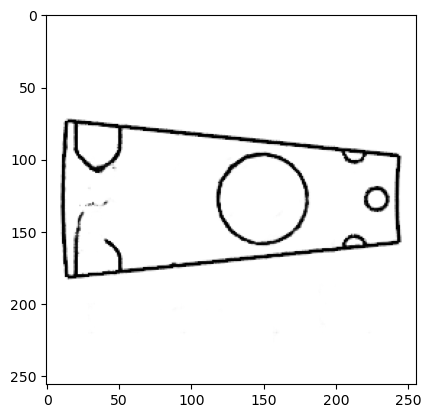

In [188]:
res=generator(tf.expand_dims(x[1499],axis=0))
plt.imshow(res[0],cmap='gray')